## Package imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack
import pyarrow
import pickle

In [2]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = list(stopwords.words('english'))
#stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Define functions

In [3]:
def clean_text(df):
    for i in [char for char in ':;"?,/|\\}{1234567890.~!@#$%^&*_+=<>']:
        df.text=df.text.apply(lambda x: str(x).replace(i,""))

    df.text=df.text.apply(lambda x: str(x).replace('-'," "))
    return df

In [4]:
#L = WordNetLemmatizer()
s = SnowballStemmer('english')

def wordPreProcess(sentence):
    return ' '.join([s.stem(x.lower()) for x in re.split('\W', sentence) if len(x) >= 1])

In [5]:
def getTextFeatures(df, txt, max_features=5000, ngrams=(1,2), verbose=True): #, max_features=10000
    if verbose:
        print('processing: ', txt)
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                                 preprocessor=wordPreProcess,
                                 max_features=max_features,
                                 binary=True,
                                 ngram_range=ngrams)
    X = vectorizer.fit_transform(df[txt])
    return X, vectorizer.get_feature_names_out()

## Import FEATURE-ENGINEERED data from EDA

In [6]:
data = pd.read_parquet('./input/consumer_complaints_FE.parquet')
data.head(10)

,product,consumer_complaint_narrative,timely_response,consumer_disputed?,label,days_between_receipt_and_sent,issue_low_flag,sub_issue_null_flag,sub_issue_low_flag,company_public_response_null_flag,company_low_flag,state_null_flag,state_low_flag,zipcode_low_flag,Older American,"Older American, Servicemember",Closed,Closed with monetary relief,Untimely response
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,1,0,4,0,0,0,0,1,1,0,0,1,1,0,0,0,0
1,Consumer Loan,Due to inconsistencies in the amount owed that...,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,1,1,6,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,Mortgage,I have an open and current mortgage with Chase...,1,1,6,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,1,1,6,0,1,1,0,1,1,0,0,0,1,0,0,0,0
5,Mortgage,Experian is reporting my OPEN and CURRENT Mort...,1,0,6,6,0,1,0,0,0,0,0,0,1,0,0,0,0
6,Mortgage,This complaint is against Wells Fargo Bank for...,1,0,6,0,0,1,0,1,0,0,0,1,0,0,0,0,0
7,Mortgage,I spoke to XXXX of green tree representatives ...,1,0,6,0,0,1,0,1,0,0,0,1,0,0,0,0,0
8,Credit card,i opened XXXX Bank of America credit cards 15-...,1,1,2,0,0,1,0,0,0,0,0,1,0,0,0,1,0
9,Consumer Loan,I applied for a loan with XXXX XXXX and had pu...,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0


In [7]:
# save data to df so won't have to reload data if need to start over with df.
df = data.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   product                            66806 non-null  object
 1   consumer_complaint_narrative       66806 non-null  object
 2   timely_response                    66806 non-null  int32 
 3   consumer_disputed?                 66806 non-null  int32 
 4   label                              66806 non-null  int32 
 5   days_between_receipt_and_sent      66806 non-null  int64 
 6   issue_low_flag                     66806 non-null  int32 
 7   sub_issue_null_flag                66806 non-null  int32 
 8   sub_issue_low_flag                 66806 non-null  int32 
 9   company_public_response_null_flag  66806 non-null  int32 
 10  company_low_flag                   66806 non-null  int32 
 11  state_null_flag                    66806 non-null  int32 
 12  stat

In [9]:
df.shape

(66806, 19)

In [10]:
list(df.columns)

['product',
 'consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'label',
 'days_between_receipt_and_sent',
 'issue_low_flag',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_null_flag',
 'company_low_flag',
 'state_null_flag',
 'state_low_flag',
 'zipcode_low_flag',
 'Older American',
 'Older American, Servicemember',
 'Closed',
 'Closed with monetary relief',
 'Untimely response']

In [11]:
product = df['product'].value_counts()
print(product)

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


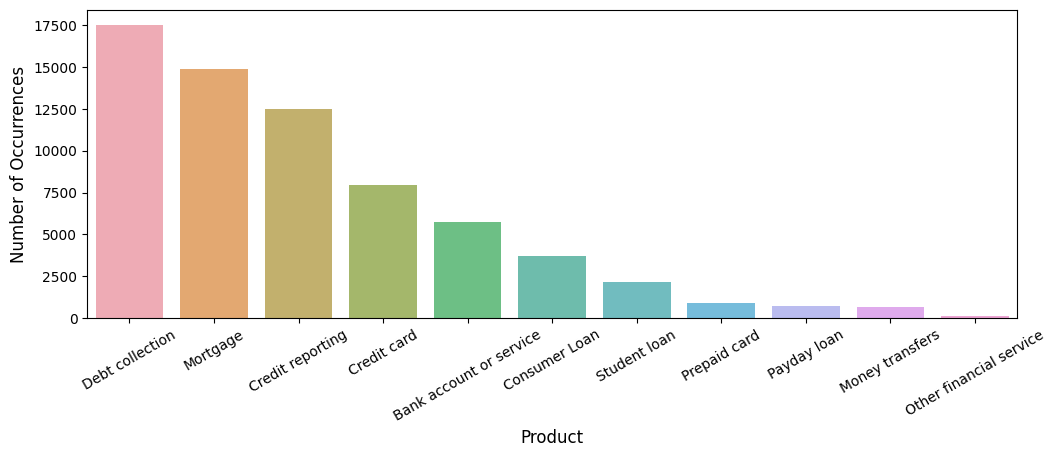

In [12]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [13]:
for i in df['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! 
They continue to insist I owe them and collection agencies are after me. 
How can I stop this harassment for a bill I already paid four years ago? 

#####################
Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining

In [14]:
df = df.rename({'consumer_complaint_narrative':'text'},axis=1) #, 'product':'label'

In [15]:
df['text'] = df['text'].astype(str)

In [16]:
df.head()

,product,text,timely_response,consumer_disputed?,label,days_between_receipt_and_sent,issue_low_flag,sub_issue_null_flag,sub_issue_low_flag,company_public_response_null_flag,company_low_flag,state_null_flag,state_low_flag,zipcode_low_flag,Older American,"Older American, Servicemember",Closed,Closed with monetary relief,Untimely response
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,1,0,4,0,0,0,0,1,1,0,0,1,1,0,0,0,0
1,Consumer Loan,Due to inconsistencies in the amount owed that...,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,1,1,6,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,Mortgage,I have an open and current mortgage with Chase...,1,1,6,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,1,1,6,0,1,1,0,1,1,0,0,0,1,0,0,0,0


## Sanitize and vectorize text

In [17]:
df = clean_text(df)

In [18]:
X_text, feat_text = getTextFeatures(df, 'text')

processing:  text


c:\Miniconda\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [19]:
print(X_text)

  (0, 4971)	0.16561904809480174
  (0, 1754)	0.26636888787163054
  (0, 203)	0.22365830584947977
  (0, 3958)	0.2619335812486446
  (0, 894)	0.14766461202505765
  (0, 717)	0.2606784861169404
  (0, 3006)	0.23642049527306408
  (0, 3186)	0.2476183440143874
  (0, 4927)	0.15260029231073144
  (0, 2871)	0.1853503057215472
  (0, 860)	0.22115749727707837
  (0, 4636)	0.2108612506766266
  (0, 179)	0.13975713778412782
  (0, 1753)	0.21647967772925253
  (0, 2879)	0.09908123962976813
  (0, 202)	0.1405638338092625
  (0, 569)	0.11730573254807165
  (0, 1903)	0.15482017344254168
  (0, 3955)	0.1349832894429062
  (0, 172)	0.11841887712565843
  (0, 891)	0.09891690865826656
  (0, 2110)	0.20079812332469088
  (0, 1024)	0.11590478672554481
  (0, 2148)	0.22912396180812358
  (0, 826)	0.10935226522853173
  :	:
  (66805, 3164)	0.04839373956643697
  (66805, 4924)	0.02396194138933754
  (66805, 3538)	0.048249824055887174
  (66805, 2410)	0.04573509575777334
  (66805, 3273)	0.06673490202603373
  (66805, 3031)	0.058708881898

In [20]:
#Saving the text features into an NPZ file
sparse.save_npz("./bin/tfidf/X_text_FE.npz", X_text)

## Combine text matrix with engineered features from EDA

In [21]:
# get engineered features together in place
numFeatures =['timely_response', 'consumer_disputed?', 'consumer_disputed?', 'label', 'days_between_receipt_and_sent',
              'issue_low_flag', 'sub_issue_null_flag', 'sub_issue_low_flag', 'company_public_response_null_flag',
              'company_low_flag', 'state_null_flag', 'state_low_flag', 'zipcode_low_flag', 'Older American',
              'Older American, Servicemember', 'Closed', 'Closed with monetary relief', 'Untimely response' ]

In [22]:
X = hstack((X_text, StandardScaler().fit_transform(df[numFeatures]))).tocsr()

In [23]:
#Saving the combined features into an NPZ file
sparse.save_npz("./bin/tfidf/X_combined_FE.npz", X)

In [ ]:
X = sparse.load_npz("./bin/tfidf/X_combined_FE.npz")

## Used cat.codes to factorize target from product previously.
## Used LabelEncoder to encode label from product during EDA.
## Will evaluate differences.

In [24]:
df['target'] = df['product'].astype('category').cat.codes  ## better way to factorize product code to categorical IDs

In [26]:
df['target'].value_counts()

4     17552
6     14919
3     12526
2      7929
0      5711
1      3678
10     2128
9       861
8       726
5       666
7       110
Name: target, dtype: int64

In [27]:
df['label'].value_counts()

4     17552
6     14919
3     12526
2      7929
0      5711
1      3678
10     2128
9       861
8       726
5       666
7       110
Name: label, dtype: int64

In [29]:
# No difference between factorized and label encoded - will use label encoded for y target.
y = df['label'].values
print(X.shape)
print(y.shape)

(66806, 5018)
(66806,)


## Stratified shuffle split data into training and test datasets

In [30]:
# Use stratified shuffle split to keep same class proportions in train and test data.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=2022)

In [31]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [21552 17614 26675 ... 21287 55579 26041] TEST: [38106 56208   152 ... 62311   397 32064]
TRAIN: [31334 33221 32682 ... 43019 57821  1023] TEST: [45340 25255 49937 ...  9552 47021 23457]


In [32]:
# Baseline label classifier with logistic regression - minimal params

log_base = LogisticRegression(
    max_iter=10000,
    random_state=2022
)

log_base.fit(X_train, y_train)

y_pred = log_base.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing f1 score %s' % f1_score(y_test, y_pred, average='weighted'))
cm_log_base = confusion_matrix(y_test, y_pred) # can use to make heatmap
cr_log_base = pd.DataFrame(classification_report(y_test, y_pred, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_log_base

Testing accuracy 0.9988774135608441
Testing f1 score 0.998674412560416


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,1142.000000
1,1.000000,0.998641,0.999320,736.000000
2,0.999370,1.000000,0.999685,1586.000000
3,1.000000,1.000000,1.000000,2505.000000
4,1.000000,1.000000,1.000000,3511.000000
5,0.992481,0.992481,0.992481,133.000000
6,0.995995,1.000000,0.997993,2984.000000
7,1.000000,0.409091,0.580645,22.000000
8,1.000000,1.000000,1.000000,145.000000
9,0.994220,1.000000,0.997101,172.000000


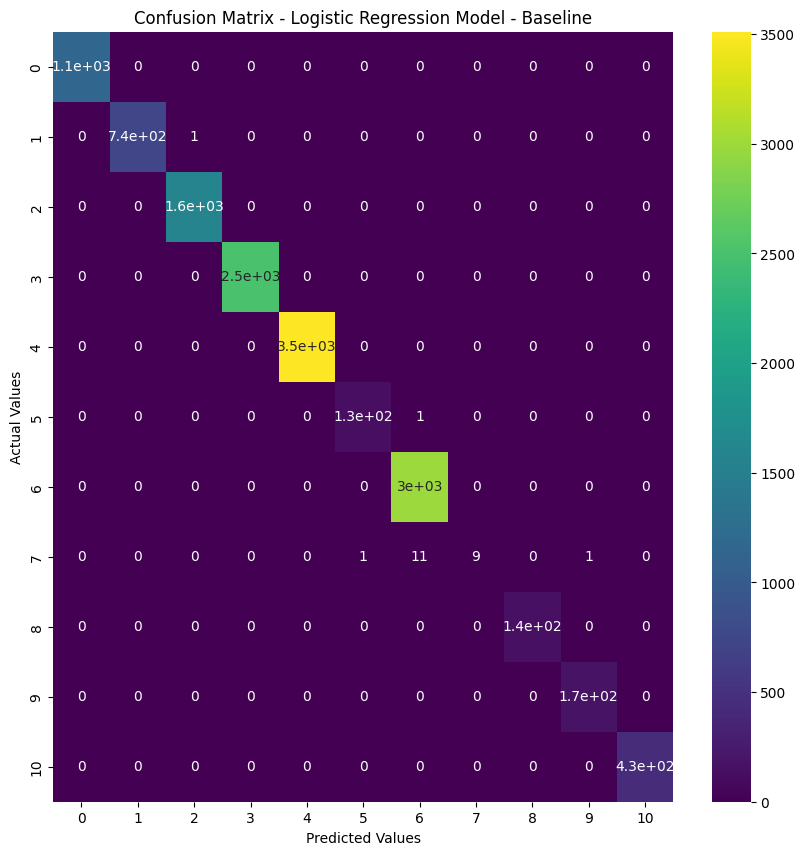

In [33]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log_base, annot=True, cmap='viridis') # cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Logistic Regression Model - Baseline')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Baseline logistic regression performs extremely well with accuracy and f1 score ~99.9% on the test dataset.  This will be a difficult baseline to beat - not a bad problem to have ;) 
    - ### Without EDA/FE, accuracy and f1 score was only ~84% on test data

# Try hyperparameter optimization for the logistic regression model

In [34]:
# Optimize logistic regression classifier with optuna
def log_objective(trial):
    #penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", "none"]) #use defaut l2 penalty
    tol = trial.suggest_float("tol", 0.0001, 0.0091, step=0.001, log=False)
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    #fit_intercept = trial.suggest_categorical("fit_intercept", ["True", "False"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "sag", "saga"]) #"liblinear", 
    #l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0, step=0.1, log=False) ## only used by elasticnet
        
    ## Create Model
    log = LogisticRegression(tol=tol, C=C, class_weight=class_weight, solver=solver,
                            max_iter=10000, multi_class = "multinomial", random_state = 2022) #fit_intercept=fit_intercept, l1_ratio=l1_ratio, warm_start=True
    ## Fit Model
    log.fit(X_train, y_train)

    return accuracy_score(y_test, log.predict(X_test))

In [35]:
log_study = optuna.create_study(study_name="Logistic Regression Classifier", direction="maximize")
log_study.optimize(log_objective, n_trials=10)

[I 2023-01-03 19:38:44,885] A new study created in memory with name: Logistic Regression Classifier
[I 2023-01-03 19:41:54,254] Trial 0 finished with value: 0.9964077233947014 and parameters: {'tol': 0.0001, 'C': 0.4, 'class_weight': None, 'solver': 'sag'}. Best is trial 0 with value: 0.9964077233947014.
[I 2023-01-03 19:42:30,274] Trial 1 finished with value: 0.9982038616973506 and parameters: {'tol': 0.0031, 'C': 0.6, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9982038616973506.
[I 2023-01-03 19:43:06,089] Trial 2 finished with value: 0.9921418949259093 and parameters: {'tol': 0.0021, 'C': 0.2, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 1 with value: 0.9982038616973506.
[I 2023-01-03 19:43:16,822] Trial 3 finished with value: 0.9904205957192037 and parameters: {'tol': 0.0021, 'C': 0.4, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 1 with value: 0.9982038616973506.
[I 2023-01-03 19:43:35,535] Trial 4 finished with value:

In [36]:
print("Best Params: {}".format(log_study.best_params))
print("\nBest Accuracy: {}".format(log_study.best_value))

Best Params: {'tol': 0.0031, 'C': 0.6, 'class_weight': None, 'solver': 'lbfgs'}

Best Accuracy: 0.9982038616973506


In [37]:
log_clf = LogisticRegression(**log_study.best_params, max_iter=10000, multi_class = "multinomial", random_state = 2022)
log_clf.fit(X_train, y_train)

y_pred_train = log_clf.predict(X_train)
y_pred_test = log_clf.predict(X_test)

log_train_acc = accuracy_score(y_train, y_pred_train)
log_test_acc = accuracy_score(y_test, y_pred_test)

log_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
log_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Logistic Regression Accuracy on Train Dataset: {}".format(log_train_acc))
print("\nLogistic Regression Accuracy on Test Dataset: {}".format(log_test_acc))
print("\n#####################")
print("\nLogistic Regression F1 Score on Train Dataset: {}".format(log_train_f1))
print("\nLogistic Regression F1 Score on Test Dataset: {}".format(log_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_log = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_log = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_log

Logistic Regression Accuracy on Train Dataset: 0.9993825312476611

Logistic Regression Accuracy on Test Dataset: 0.9982038616973506

#####################

Logistic Regression F1 Score on Train Dataset: 0.9993332640001746

Logistic Regression F1 Score on Test Dataset: 0.9975824948204283


,precision,recall,f1-score,support
0,0.999125,1.000000,0.999562,1142.000000
1,1.000000,0.995924,0.997958,736.000000
2,0.998741,1.000000,0.999370,1586.000000
3,1.000000,1.000000,1.000000,2505.000000
4,1.000000,1.000000,1.000000,3511.000000
5,0.992481,0.992481,0.992481,133.000000
6,0.994004,1.000000,0.996993,2984.000000
7,1.000000,0.090909,0.166667,22.000000
8,1.000000,1.000000,1.000000,145.000000
9,0.988506,1.000000,0.994220,172.000000


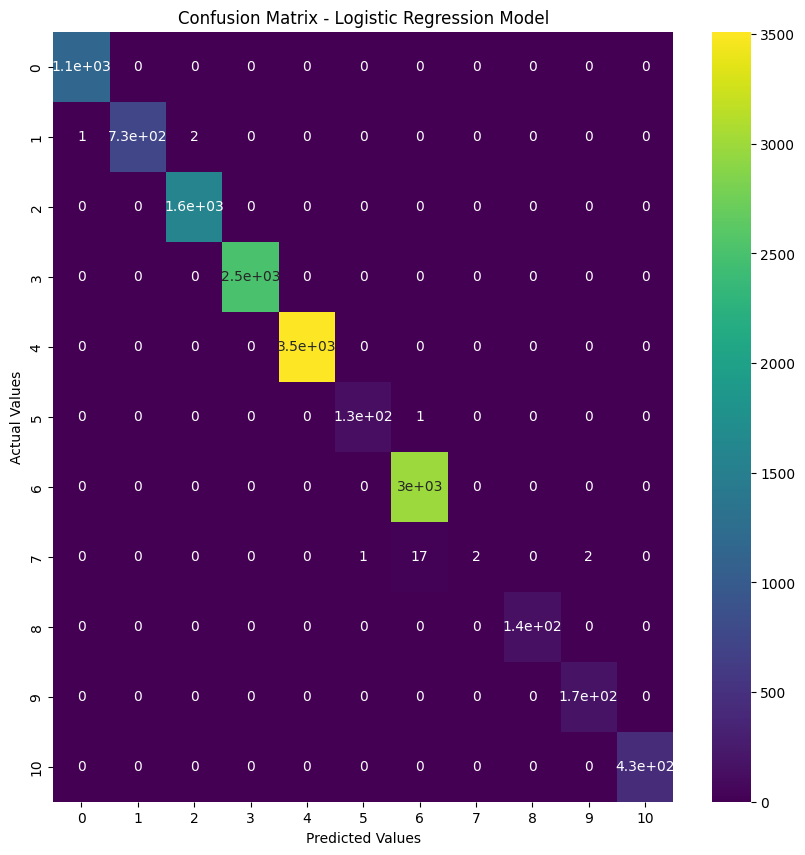

In [38]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Logistic Regression Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Hyperparameter optimization with Optuna did not improve upon stellar logistic regression baseline classification accuracy and f1 score.
- ### Classification heatmap demonstrates extremely good classification overall. 
- ### Classifier had some issue with Class 7 and predicted it as Class 6 (17 out of 22 times).
- ### Overfitting not an issue with similar metrics across training and test data.
    - ### Without EDA/FE, accuracy and f1 score was only ~84% on test data and ~88% on training data

# Try other classification model types with hyperparameter optimization

## Passive Aggressive Classifier

In [39]:
# Optimize passive aggressive classifier with optuna
def pac_objective(trial):
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    tol = trial.suggest_float("tol", 0.001, 0.01, step=0.001, log=False)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
            
    ## Create Model
    pac = PassiveAggressiveClassifier(C=C, tol=tol, loss=loss, class_weight=class_weight, 
                                        max_iter=10000, random_state = 2022) 

    ## Fit Model
    pac.fit(X_train, y_train)

    return accuracy_score(y_test, pac.predict(X_test))

In [40]:
pac_study = optuna.create_study(study_name="Passive Aggressive Classifier", direction="maximize")
pac_study.optimize(pac_objective, n_trials=10)

[I 2023-01-03 19:46:29,733] A new study created in memory with name: Passive Aggressive Classifier
[I 2023-01-03 19:46:32,090] Trial 0 finished with value: 0.9668462804969316 and parameters: {'C': 0.7000000000000001, 'tol': 0.002, 'loss': 'squared_hinge', 'class_weight': None}. Best is trial 0 with value: 0.9668462804969316.
[I 2023-01-03 19:46:35,451] Trial 1 finished with value: 0.9666217632091004 and parameters: {'C': 0.6, 'tol': 0.002, 'loss': 'hinge', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9668462804969316.
[I 2023-01-03 19:46:38,998] Trial 2 finished with value: 0.9678940278401437 and parameters: {'C': 0.4, 'tol': 0.001, 'loss': 'hinge', 'class_weight': None}. Best is trial 2 with value: 0.9678940278401437.
[I 2023-01-03 19:46:40,447] Trial 3 finished with value: 0.9635533602754078 and parameters: {'C': 0.6, 'tol': 0.01, 'loss': 'hinge', 'class_weight': None}. Best is trial 2 with value: 0.9678940278401437.
[I 2023-01-03 19:46:42,437] Trial 4 finished with val

In [41]:
print("Best Params: {}".format(pac_study.best_params))
print("\nBest Accuracy: {}".format(pac_study.best_value))

Best Params: {'C': 0.4, 'tol': 0.001, 'loss': 'hinge', 'class_weight': None}

Best Accuracy: 0.9678940278401437


In [42]:
pac_clf = PassiveAggressiveClassifier(**pac_study.best_params, max_iter=10000, random_state = 2022)
pac_clf.fit(X_train, y_train)

y_pred_train = pac_clf.predict(X_train)
y_pred_test = pac_clf.predict(X_test)

pac_train_acc = accuracy_score(y_train, y_pred_train)
pac_test_acc = accuracy_score(y_test, y_pred_test)

pac_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
pac_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Passive Aggressive Classifier Accuracy on Train Dataset: {}".format(pac_train_acc))
print("\nPassive Aggressive Classifier Accuracy on Test Dataset: {}".format(pac_test_acc))
print("\n#####################")
print("\nPassive Aggressive Classifier F1 Score on Train Dataset: {}".format(pac_train_f1))
print("\nPassive Aggressive Classifier F1 Score on Test Dataset: {}".format(pac_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_pac = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_pac = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_pac

Passive Aggressive Classifier Accuracy on Train Dataset: 0.9916173939076417

Passive Aggressive Classifier Accuracy on Test Dataset: 0.9678940278401437

#####################

Passive Aggressive Classifier F1 Score on Train Dataset: 0.9915167255624483

Passive Aggressive Classifier F1 Score on Test Dataset: 0.9671800520295847


,precision,recall,f1-score,support
0,0.957333,0.943082,0.950154,1142.000000
1,0.923754,0.855978,0.888575,736.000000
2,0.915663,0.958386,0.936537,1586.000000
3,0.972565,0.976447,0.974502,2505.000000
4,0.980057,0.979778,0.979917,3511.000000
5,0.858156,0.909774,0.883212,133.000000
6,0.995318,0.997319,0.996317,2984.000000
7,0.000000,0.000000,0.000000,22.000000
8,0.973154,1.000000,0.986395,145.000000
9,0.953757,0.959302,0.956522,172.000000


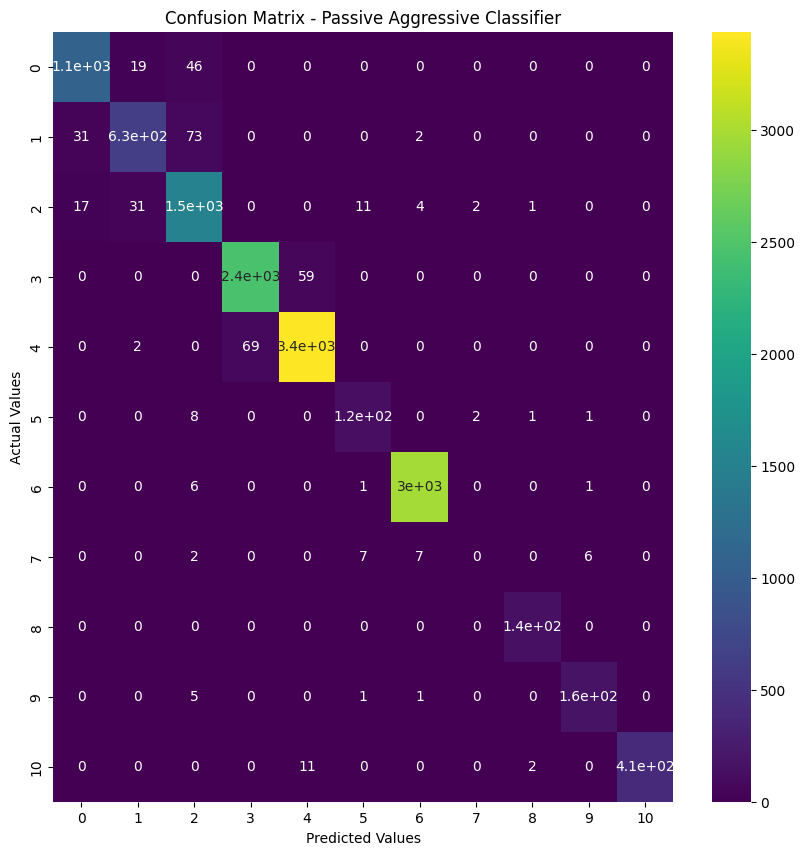

In [43]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_pac, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Passive Aggressive Classifier exhibited slightly lower accuracy and f1 score than Logistic Regression Classifier.
- ### Classification heatmap demonstrates very good classification overall but high degree of misclassifications between classes 3 and 4. 
- ### Class 7 with least amount of support (22 samples) was not correctly predicted once.
- ### Small degree of overfitting with slightly higher metrics on training data.
    - ### Without EDA/FE, accuracy and f1 score was only ~85% on test data and ~90% on training data

## Random Forest Classifier

In [44]:
# Optimize Random Forest Classifier with optuna
def rfc_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 550, step=100, log=False)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int("max_depth", 2, 10, step=2, log=False)
    min_samples_split = trial.suggest_int("min_samples_split", 20, 100, step=20, log=False)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 50, step=10, log=False)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
            
    ## Create Model
    rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, 
                                    min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, 
                                    class_weight=class_weight, random_state = 2022) 

    ## Fit Model
    rfc.fit(X_train, y_train)

    return accuracy_score(y_test, rfc.predict(X_test))

In [45]:
rfc_study = optuna.create_study(study_name="Random Forest Classifier", direction="maximize")
rfc_study.optimize(rfc_objective, n_trials=10)

[I 2023-01-03 19:46:57,008] A new study created in memory with name: Random Forest Classifier
[I 2023-01-03 19:47:20,700] Trial 0 finished with value: 0.8284687920969914 and parameters: {'n_estimators': 450, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 100, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8284687920969914.
[I 2023-01-03 20:01:20,579] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 150, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 1.0.
[I 2023-01-03 20:01:55,552] Trial 2 finished with value: 0.8622960634635534 and parameters: {'n_estimators': 450, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 60, 'min_samples_leaf': 40, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_su

In [46]:
print("Best Params: {}".format(rfc_study.best_params))
print("\nBest Accuracy: {}".format(rfc_study.best_value))

Best Params: {'n_estimators': 150, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}

Best Accuracy: 1.0


In [47]:
rfc_clf = RandomForestClassifier(**rfc_study.best_params, random_state = 2022)
rfc_clf.fit(X_train, y_train)

y_pred_train = rfc_clf.predict(X_train)
y_pred_test = rfc_clf.predict(X_test)

rfc_train_acc = accuracy_score(y_train, y_pred_train)
rfc_test_acc = accuracy_score(y_test, y_pred_test)

rfc_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
rfc_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Random Forest Classifier Accuracy on Train Dataset: {}".format(rfc_train_acc))
print("\nRandom Forest Classifier Accuracy on Test Dataset: {}".format(rfc_test_acc))
print("\n#####################")
print("\nRandom Forest Classifier F1 Score on Train Dataset: {}".format(rfc_train_f1))
print("\nRandom Forest Classifier F1 Score on Test Dataset: {}".format(rfc_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_rfc = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_rfc = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_rfc

Random Forest Classifier Accuracy on Train Dataset: 1.0

Random Forest Classifier Accuracy on Test Dataset: 1.0

#####################

Random Forest Classifier F1 Score on Train Dataset: 1.0

Random Forest Classifier F1 Score on Test Dataset: 1.0


,precision,recall,f1-score,support
0,1.0,1.0,1.0,1142.0
1,1.0,1.0,1.0,736.0
2,1.0,1.0,1.0,1586.0
3,1.0,1.0,1.0,2505.0
4,1.0,1.0,1.0,3511.0
5,1.0,1.0,1.0,133.0
6,1.0,1.0,1.0,2984.0
7,1.0,1.0,1.0,22.0
8,1.0,1.0,1.0,145.0
9,1.0,1.0,1.0,172.0


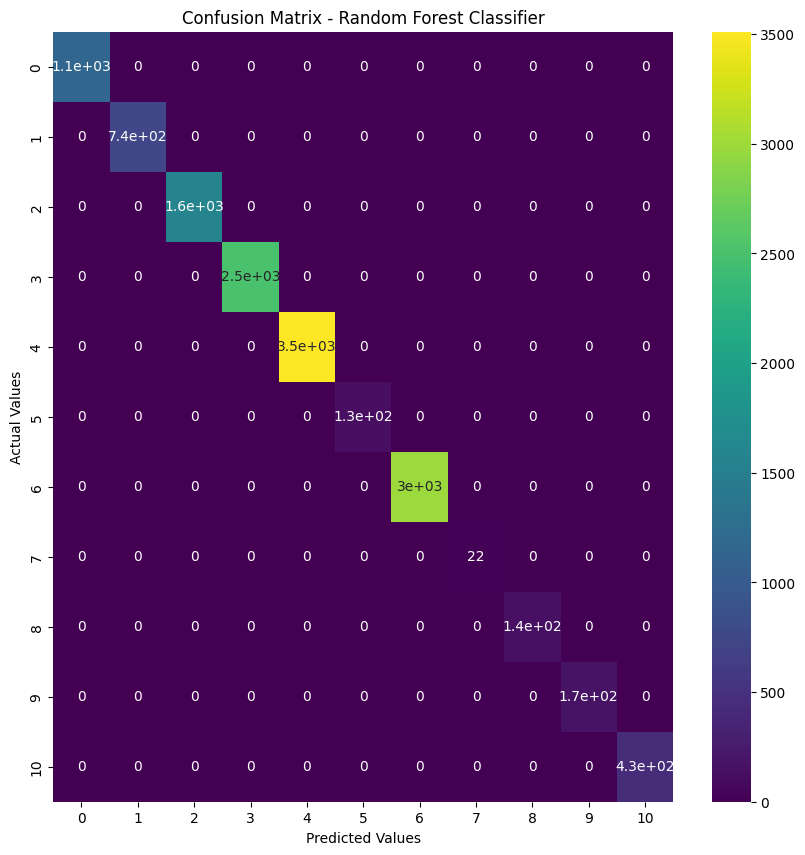

In [48]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Random Forest Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Random Forest Classifier performed slightly better than Passive Aggressive and Logistic Regression Classifiers with perfect accuracy and f1 score on test and training data.
- ### Classification heatmap demonstrates perfect classification with no misclassifications. 
- ### Class 7 with least amount of support (22 samples) was predicted correctly every time.
- ### No evidence of overfitting with the same metrics between training and test data.
    - ### Without EDA/FE, accuracy and f1 score was only ~76% on test data and ~77% on training data

## XGBoost Classifier

In [49]:
# Optimize XGBoost Classifier with optuna   ## may be better to use xgboost w/o any hyperparams/optuna to overfit and then regularize after to reduce overfit
def xgb_objective(trial):
    #booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    eta = trial.suggest_float("eta", 0.1, 1.0, step=0.1, log=False)
    gamma = trial.suggest_int("gamma", 0, 100, step=10, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 42, step=4, log=False)
    min_child_weight = trial.suggest_int("min_child_weight", 0, 50, step=10, log=False)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1, log=False)
    #sampling_method = trial.suggest_categorical("sampling_method", ["uniform", "gradient_based"]) #gradient_based only for tree_method: gpu_hist
            
    ## Create Model
    xgb = XGBClassifier(booster="gbtree", eta=eta, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, 
                            subsample=subsample, eval_metric="mlogloss", use_label_encoder=False, random_state = 2022) # booster=booster, sampling_method=sampling_method,

    ## Fit Model
    xgb.fit(X_train, y_train)

    return accuracy_score(y_test, xgb.predict(X_test))

In [50]:
xgb_study = optuna.create_study(study_name="XGBoost Classifier", direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=10)

[I 2023-01-03 20:33:04,655] A new study created in memory with name: XGBoost Classifier
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-01-03 20:35:03,247] Trial 0 finished with value: 1.0 and parameters: {'eta': 0.30000000000000004, 'gamma': 70, 'max_depth': 14, 'min_child_weight': 0, 'subsample': 1.0}. Best is trial 0 with value: 1.0.
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-01-03 20:35:51,096] Trial 1 finished with value: 0.9983535398892381 and parameters: {'eta': 0.6, 'gamma': 40, 'max_depth': 22, 'min_child_weight': 40, 'subsample': 0.6}. Best is trial 0 with value: 1.0.
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
 

In [51]:
print("Best Params: {}".format(xgb_study.best_params))
print("\nBest Accuracy: {}".format(xgb_study.best_value))

Best Params: {'eta': 0.30000000000000004, 'gamma': 70, 'max_depth': 14, 'min_child_weight': 0, 'subsample': 1.0}

Best Accuracy: 1.0


In [52]:
xgb_clf = XGBClassifier(**xgb_study.best_params, booster="gbtree", use_label_encoder=False, eval_metric="mlogloss", random_state = 2022)
xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)

xgb_train_acc = accuracy_score(y_train, y_pred_train)
xgb_test_acc = accuracy_score(y_test, y_pred_test)

xgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
xgb_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("XGBoost Classifier Accuracy on Train Dataset: {}".format(xgb_train_acc))
print("\nXGBoost Classifier Accuracy on Test Dataset: {}".format(xgb_test_acc))
print("\n#####################")
print("\nXGBoost Classifier F1 Score on Train Dataset: {}".format(xgb_train_f1))
print("\nXGBoost Classifier F1 Score on Test Dataset: {}".format(xgb_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_xgb = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_xgb = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_xgb

c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost Classifier Accuracy on Train Dataset: 1.0

XGBoost Classifier Accuracy on Test Dataset: 1.0

#####################

XGBoost Classifier F1 Score on Train Dataset: 1.0

XGBoost Classifier F1 Score on Test Dataset: 1.0


,precision,recall,f1-score,support
0,1.0,1.0,1.0,1142.0
1,1.0,1.0,1.0,736.0
2,1.0,1.0,1.0,1586.0
3,1.0,1.0,1.0,2505.0
4,1.0,1.0,1.0,3511.0
5,1.0,1.0,1.0,133.0
6,1.0,1.0,1.0,2984.0
7,1.0,1.0,1.0,22.0
8,1.0,1.0,1.0,145.0
9,1.0,1.0,1.0,172.0


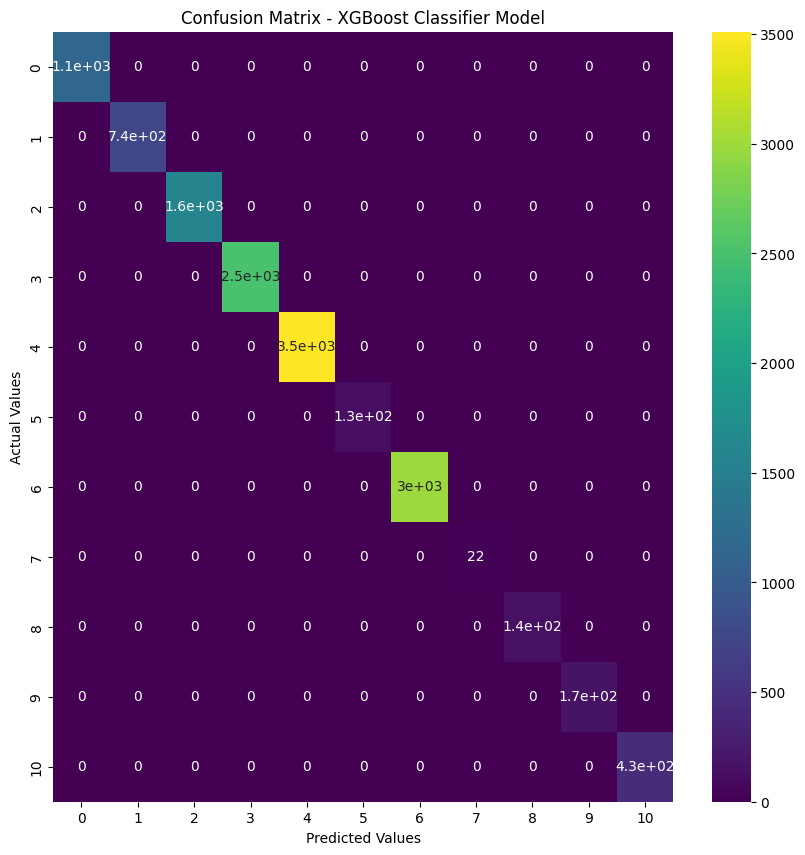

In [53]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_xgb, annot=True, cmap='viridis') #, ax=ax) #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - XGBoost Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### XGBoost Classifier performed the same as Random Forest Classifier with perfect accuracy and f1 score on test and training data.
- ### Classification heatmap demonstrates perfect classification with no misclassifications. 
- ### Class 7 with least amount of support (22 samples) was predicted correctly every time.
- ### No evidence of overfitting with the same metrics between training and test data.
    - ### Without EDA/FE, accuracy and f1 score was only ~85% on test data and ~95% on training data

## LightGBM Classifier

In [54]:
# Optimize LightGBM Classifier Classifier with optuna
def lgb_objective(trial):
    #boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss", "rf"])
    num_leaves = trial.suggest_int("num_leaves", 4, 20, step=4, log=False) #decrease
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2, log=False) #decrease
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.010, step=0.001, log=False)
    n_estimators = trial.suggest_int("n_estimators", 350, 500, step=25, log=False) #increase
    min_child_weight = trial.suggest_float("min_child_weight", 0.01, 0.10, step=0.01, log=False) #increase ## may be too high
    min_child_samples = trial.suggest_int("min_child_samples", 100, 200, step=25, log=False) #decrease  ## may be too high
    subsample = trial.suggest_float("subsample", 0.2, 1.0, step=0.2, log=False)
            
    ## Create Model
    lgb = LGBMClassifier(boosting_type="gbdt", num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, 
                            n_estimators=n_estimators, min_child_weight=min_child_weight, min_child_samples=min_child_samples, 
                            subsample=subsample, objective="multiclass", random_state = 2022) #class_weight=class_weights_dict, 

    ## Fit Model
    lgb.fit(X_train, y_train)

    return accuracy_score(y_test, lgb.predict(X_test))

In [55]:
lgb_study = optuna.create_study(study_name="LightGBM Classifier", direction="maximize")
lgb_study.optimize(lgb_objective, n_trials=10)

[I 2023-01-03 20:46:30,814] A new study created in memory with name: LightGBM Classifier
[I 2023-01-03 20:59:10,799] Trial 0 finished with value: 1.0 and parameters: {'num_leaves': 20, 'max_depth': 8, 'learning_rate': 0.002, 'n_estimators': 500, 'min_child_weight': 0.01, 'min_child_samples': 200, 'subsample': 0.2}. Best is trial 0 with value: 1.0.
[I 2023-01-03 21:05:11,865] Trial 1 finished with value: 1.0 and parameters: {'num_leaves': 8, 'max_depth': 2, 'learning_rate': 0.004, 'n_estimators': 400, 'min_child_weight': 0.060000000000000005, 'min_child_samples': 150, 'subsample': 0.6000000000000001}. Best is trial 0 with value: 1.0.
[I 2023-01-03 21:10:49,714] Trial 2 finished with value: 1.0 and parameters: {'num_leaves': 4, 'max_depth': 8, 'learning_rate': 0.006, 'n_estimators': 400, 'min_child_weight': 0.06999999999999999, 'min_child_samples': 200, 'subsample': 1.0}. Best is trial 0 with value: 1.0.
[I 2023-01-03 21:19:31,578] Trial 3 finished with value: 1.0 and parameters: {'num_l

In [56]:
print("Best Params: {}".format(lgb_study.best_params))
print("\nBest Accuracy: {}".format(lgb_study.best_value))

Best Params: {'num_leaves': 20, 'max_depth': 8, 'learning_rate': 0.002, 'n_estimators': 500, 'min_child_weight': 0.01, 'min_child_samples': 200, 'subsample': 0.2}

Best Accuracy: 1.0


In [57]:
lgb_clf = LGBMClassifier(**lgb_study.best_params, boosting_type="gbdt", objective="multiclass", random_state = 2022)
lgb_clf.fit(X_train, y_train)

y_pred_train = lgb_clf.predict(X_train)
y_pred_test = lgb_clf.predict(X_test)

lgb_train_acc = accuracy_score(y_train, y_pred_train)
lgb_test_acc = accuracy_score(y_test, y_pred_test)

lgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
lgb_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("LightGBM Classifier Accuracy on Train Dataset: {}".format(lgb_train_acc))
print("\nLightGBM Classifier Accuracy on Test Dataset: {}".format(lgb_test_acc))
print("\n#####################")
print("\nLightGBM Classifier F1 Score on Train Dataset: {}".format(lgb_train_f1))
print("\nLightGBM Classifier F1 Score on Test Dataset: {}".format(lgb_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_lgb = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_lgb = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_lgb

LightGBM Classifier Accuracy on Train Dataset: 1.0

LightGBM Classifier Accuracy on Test Dataset: 1.0

#####################

LightGBM Classifier F1 Score on Train Dataset: 1.0

LightGBM Classifier F1 Score on Test Dataset: 1.0


,precision,recall,f1-score,support
0,1.0,1.0,1.0,1142.0
1,1.0,1.0,1.0,736.0
2,1.0,1.0,1.0,1586.0
3,1.0,1.0,1.0,2505.0
4,1.0,1.0,1.0,3511.0
5,1.0,1.0,1.0,133.0
6,1.0,1.0,1.0,2984.0
7,1.0,1.0,1.0,22.0
8,1.0,1.0,1.0,145.0
9,1.0,1.0,1.0,172.0


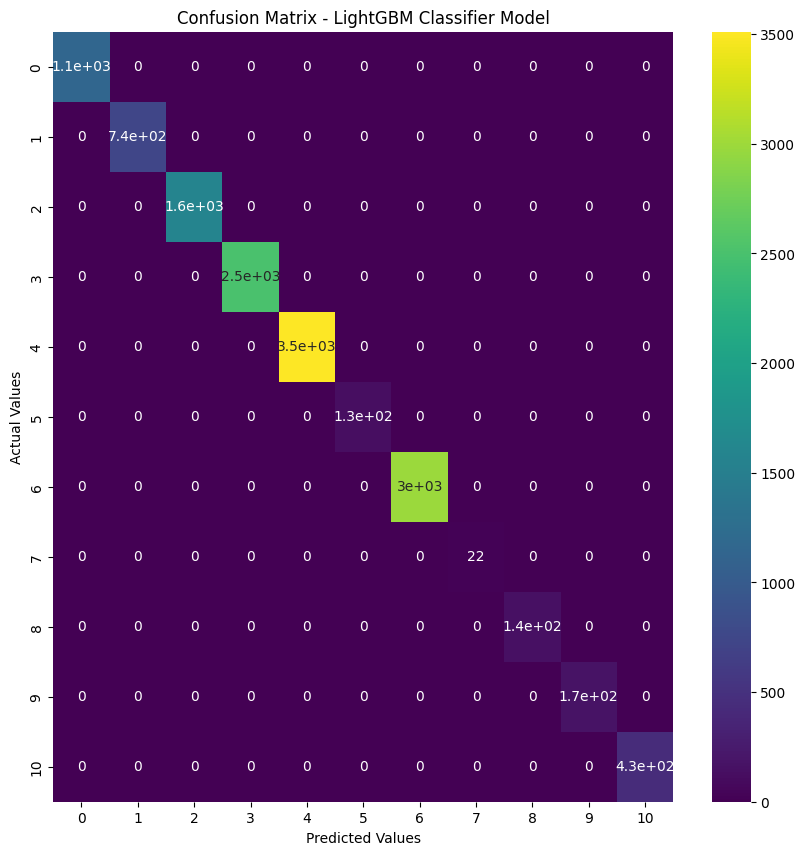

In [58]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lgb, annot=True, cmap='viridis') #, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - LightGBM Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### LightGBM Classifier performed the same as XGBoost Classifier and Random Forest Classifier with perfect accuracy and f1 score on test and training data.
- ### Classification heatmap demonstrates perfect classification with no misclassifications. 
- ### Class 7 with least amount of support (22 samples) was predicted correctly every time.
- ### No evidence of overfitting with the same metrics between training and test data.
    - ### Without EDA/FE, accuracy and f1 score was only ~81% on test data and ~82% on training data

## Save Models

In [59]:
pickle.dump(log_clf, open('./bin/tfidf/log_clf_FE.pkl', 'wb'))
pickle.dump(pac_clf, open('./bin/tfidf/pac_clf_FE.pkl', 'wb'))
pickle.dump(rfc_clf, open('./bin/tfidf/rfc_clf_FE.pkl', 'wb'))
pickle.dump(xgb_clf, open('./bin/tfidf/xgb_clf_FE.pkl', 'wb'))
pickle.dump(lgb_clf, open('./bin/tfidf/lgb_clf_FE.pkl', 'wb'))

## Ensemble best models together to balance bias-variance tradeoff for out-of-sample data.

In [60]:
# load 3 best saved models
rfc_clf = pickle.load(open('./bin/tfidf/rfc_clf_FE.pkl', 'rb'))
xgb_clf = pickle.load(open('./bin/tfidf/xgb_clf_FE.pkl', 'rb'))
lgb_clf = pickle.load(open('./bin/tfidf/lgb_clf_FE.pkl', 'rb'))

In [61]:
ensemble_clf = VotingClassifier(estimators=[('rfc', rfc_clf), ('xgb', xgb_clf), ('lgb', lgb_clf)], 
                                    voting='soft') # can use 'soft' argmax voting since each classifier has predict_proba

In [62]:
ensemble_clf = ensemble_clf.fit(X_train, y_train)

c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [63]:
y_pred_train_ensemble = ensemble_clf.predict(X_train)
y_pred_test_ensemble = ensemble_clf.predict(X_test)

In [64]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_test_acc = accuracy_score(y_test, y_pred_test_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_test_f1 = f1_score(y_test, y_pred_test_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Test Dataset: {}".format(results_ensemble_test_acc))
print("\n#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Test Dataset: {}".format(results_ensemble_test_f1))

Ensemble Accuracy on Train Dataset: 1.0

Ensemble Accuracy on Test Dataset: 1.0

#####################

Ensemble F1 Score on Train Dataset: 1.0

Ensemble F1 Score on Test Dataset: 1.0


- ### Perfect accuracy and f1 score on test and training data with ensemble model.
- ### No need to engineer additional features from text.